## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde

######################
# ITER shape #
######################
eps = 0.32
kappa = 1.7
delta = 0.33
Amax = 1e-5

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################

    N = num
    center = np.array([[0.0,0.0,0.0]])
    tau = np.linspace(0, 2 * np.pi, N)
    Arange = np.linspace(-Amax, Amax, N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau), Arange]).T
    print(x_ellipse.shape)
    uvals = np.zeros(len(x_ellipse)).reshape(len(x_ellipse), 1)
    return x_ellipse, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    A = x[:, 2:3]
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

spatial_domain = dde.geometry.Ellipse_A(eps, kappa, delta, Amax=Amax) 

x, u = gen_traindata(400)

n_test = 100
x_test,u_test = gen_traindata(n_test)
x_domain = spatial_domain.random_points(n_test)
x_test = np.concatenate((x_test, x_domain))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=2048,
    num_boundary=0,
    x_test=x_test,
    y_test=u_test,
    train_distribution="LHS"
)


Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term
(400, 3)
(100, 3)


Text(0, 0.5, '$u(r,z=0)$')

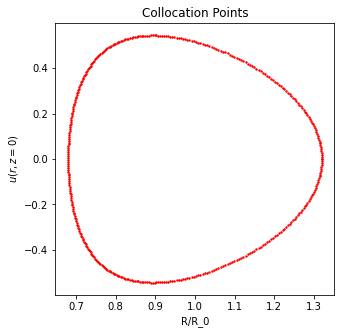

In [2]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

In [3]:
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)

## Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.068525 s



/Users/alankaptanoglu/deepxde_copy/deepxde/maps/fnn.py:112: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 1.432446 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.03e+00, 1.38e-03]    [1.05e+00, 0.00e+00]    []  
10        [2.07e-01, 1.69e-02]    [2.78e-01, 0.00e+00]    []  
20        [7.07e-02, 1.05e-02]    [1.04e-01, 0.00e+00]    []  
30        [7.06e-03, 4.66e-03]    [1.22e-02, 0.00e+00]    []  
40        [3.00e-03, 3.31e-03]    [1.83e-03, 0.00e+00]    []  
50        [1.45e-03, 9.10e-04]    [1.33e-03, 0.00e+00]    []  
60        [7.20e-04, 4.58e-04]    [1.27e-03, 0.00e+00]    []  
70        [2.47e-04, 3.53e-04]    [4.34e-04, 0.00e+00]    []  
80        [2.49e-04, 1.92e-04]    [5.13e-04, 0.00e+00]    []  
90        [1.41e-04, 1.75e-04]    [3.12e-04, 0.00e+00]    []  
100       [1.26e-04, 1.41e-04]    [2.79e-04, 0.00e+00]    []  

Best model at step 100:
  train loss: 2.67e-04
  test loss: 2.79e-04
  test metric: []

'train' took 4.085375 s

Saving loss history to ./cefron/ITER/runs/network_s

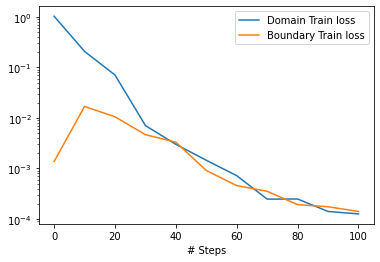

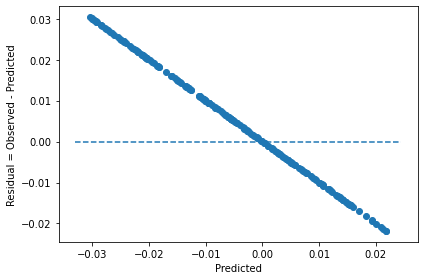

In [4]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-2
DEPTH = 3
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([3] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,1]
  )
  loss_history, train_state = model.train(epochs=100, display_every = 10)
  dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

#### After BFGS

Compiling model...
'compile' took 1.185699 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.26e-04, 1.41e-02]    [2.79e-04, 0.00e+00]    []  
110       [4.78e-03, 4.48e-03]                                
120       [6.14e-04, 2.52e-03]                                
130       [1.96e-04, 2.46e-03]                                
140       [2.15e-04, 2.09e-03]                                
150       [8.55e-05, 7.39e-04]                                
160       [2.25e-04, 3.48e-04]                                
170       [6.63e-05, 8.79e-05]                                
180       [4.66e-05, 5.42e-05]                                
190       [2.74e-05, 3.30e-05]                                
200       [2.12e-05, 7.91e-06]                                
210       [1.91e-05, 7.67e-06]                                
220       [1.47e-05, 7.21e-06]                                
230       [1.46e-05, 7.22e-06]                

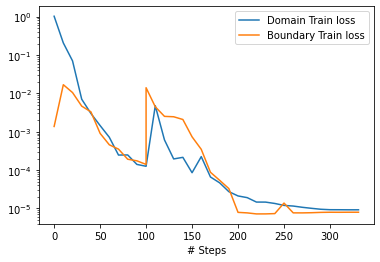

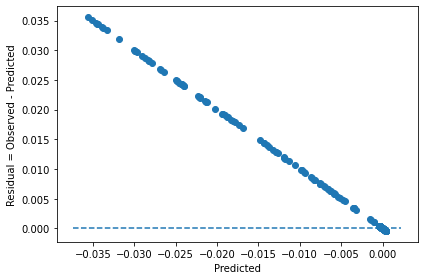

In [5]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


In [6]:
# Evaluation
from utils.utils import evaluate_A, relative_error_plot
ITER = GS_Linear(eps=eps, kappa=kappa, delta=delta)
xfull,yfull,A,psi_pred_full,psi_true_full,error=evaluate_A(ITER,model)
# X_test = spatial_domain.random_points(300)


[[0.02373833 0.02273908 0.02178682 ... 0.19077391 0.20336314 0.21654272]
 [0.02317474 0.02204954 0.02096732 ... 0.17815365 0.19032442 0.20307711]
 [0.02263069 0.02138334 0.0201751  ... 0.16597887 0.17774706 0.19008909]
 ...
 [0.02263069 0.02138334 0.0201751  ... 0.16597887 0.17774706 0.19008909]
 [0.02317474 0.02204954 0.02096732 ... 0.17815365 0.19032442 0.20307711]
 [0.02373833 0.02273908 0.02178682 ... 0.19077391 0.20336314 0.21654272]] [[0.02725672 0.02595905 0.02473152 ... 0.18308729 0.19473244 0.206897  ]
 [0.02650372 0.02507515 0.02371296 ... 0.17083252 0.18209934 0.19387874]
 [0.02578474 0.02422966 0.02273734 ... 0.1590315  0.16993443 0.18134341]
 ...
 [0.02578474 0.02422966 0.02273734 ... 0.1590315  0.16993443 0.18134341]
 [0.02650372 0.02507515 0.02371296 ... 0.17083252 0.18209934 0.19387874]
 [0.02725672 0.02595905 0.02473152 ... 0.18308729 0.19473244 0.206897  ]] 51


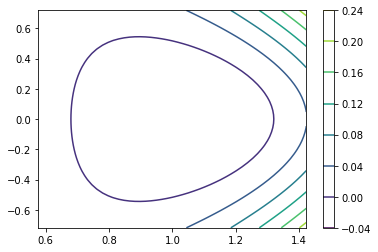

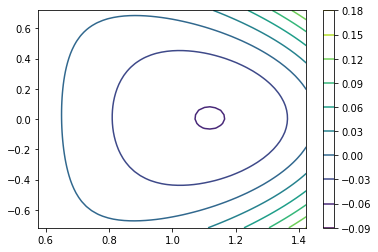

In [7]:
print(psi_true_full[:, :, 0], psi_true_full[:, :, -1], xfull.shape[2])
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_true_full[:, :, 0])
plt.colorbar()
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_pred_full[:, :, 0])
plt.colorbar()

0
5
10
15
20
25
30
35
40
45
50


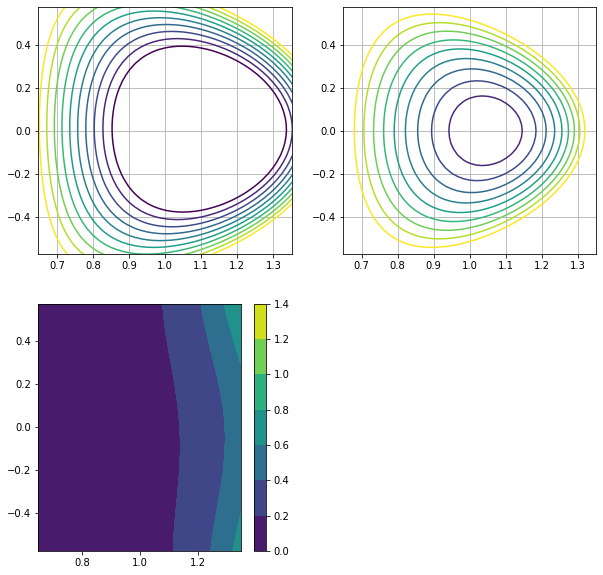

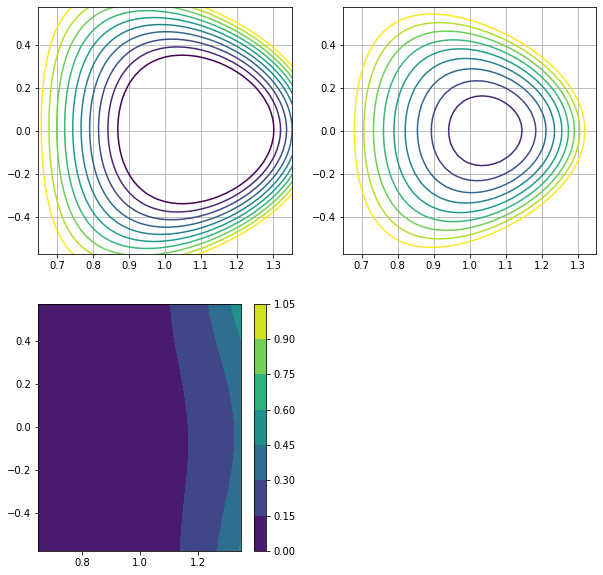

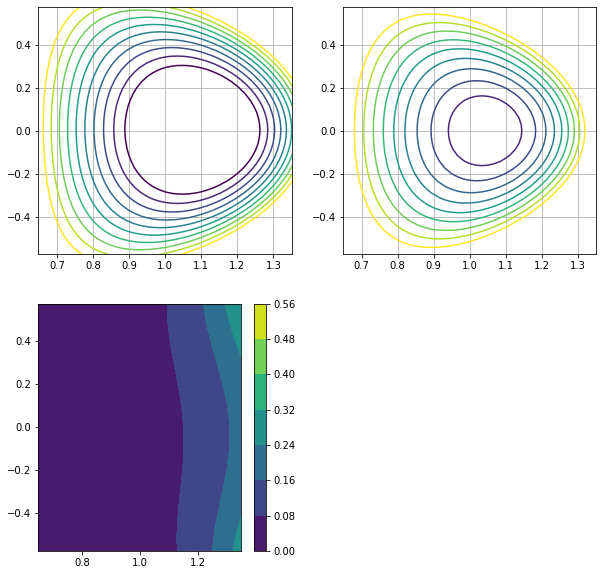

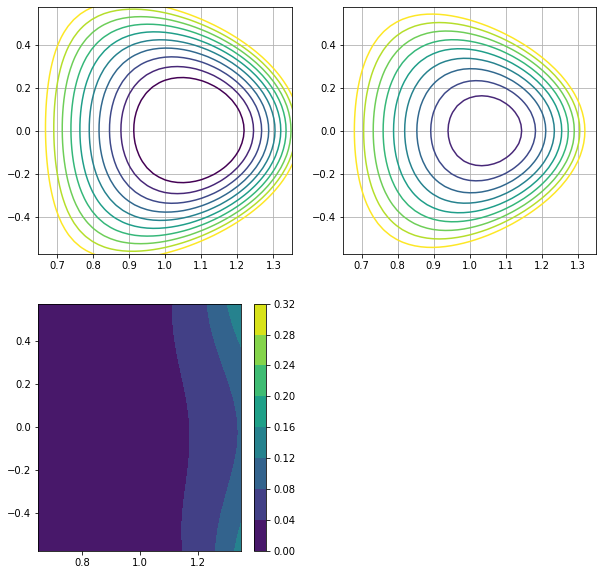

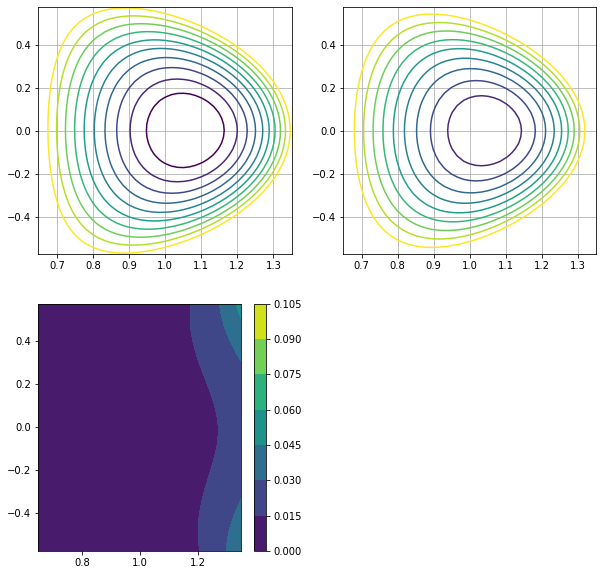

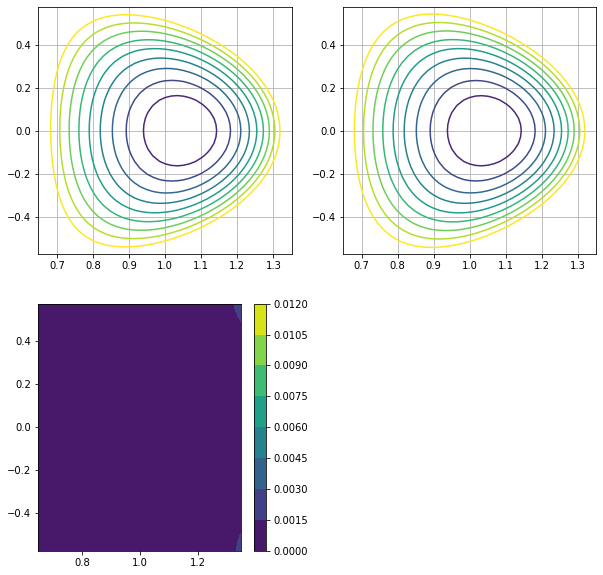

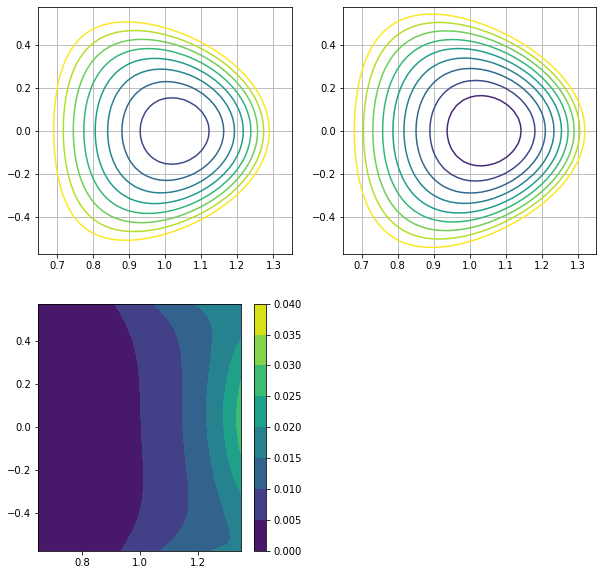

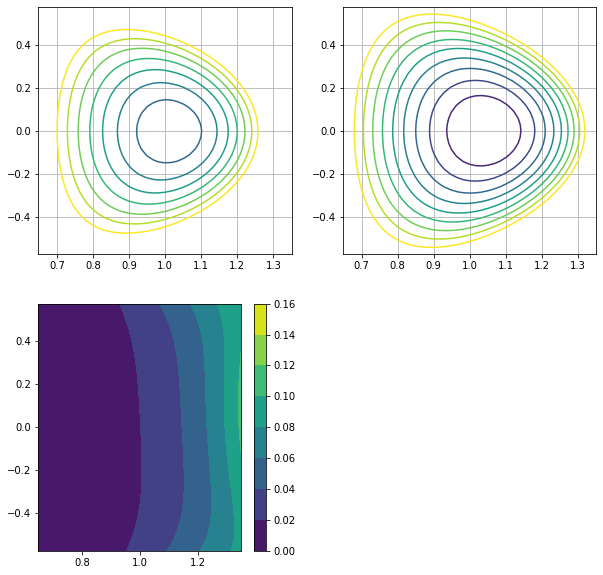

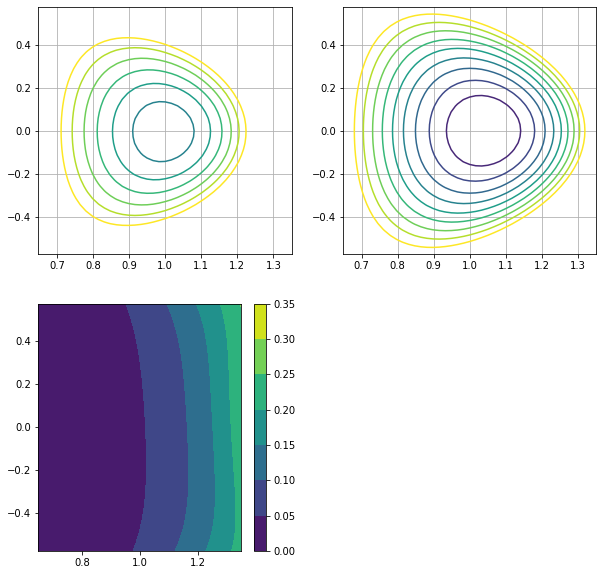

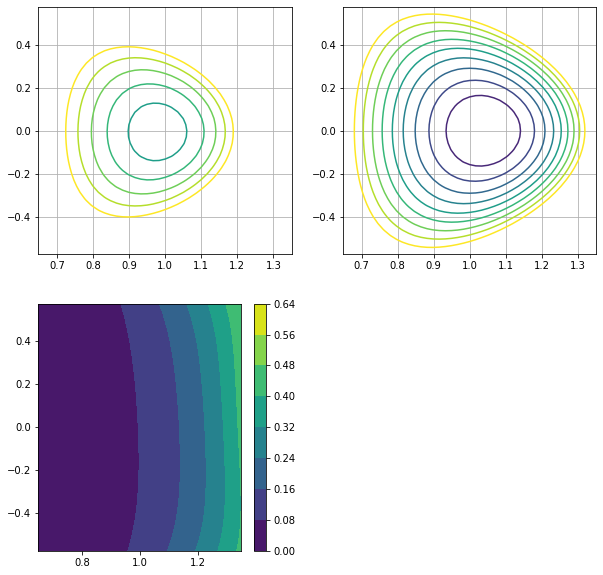

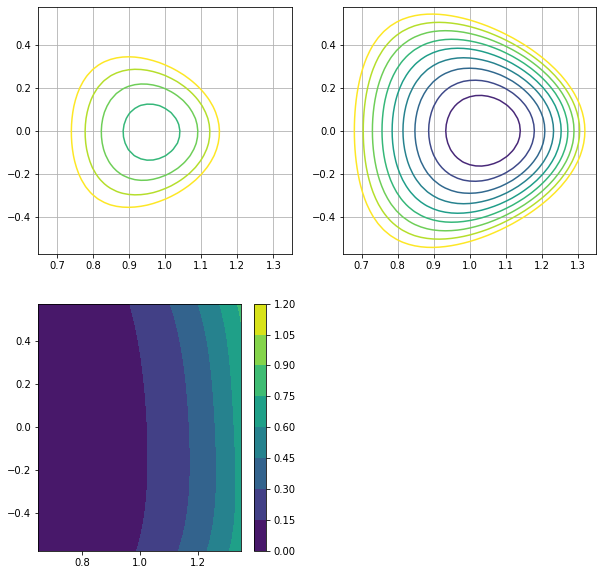

In [8]:
# Plotting Setup
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom

for i in range(0, xfull.shape[2], 5):
    print(i)
    plt.figure(i + 1, figsize=(10,10))

    levels = np.linspace(min(psi_true_full[:, :, i].reshape(-1)),0,10)
#     print(levels)
    
    plt.subplot(2, 2, 1)
    # Plot 1 - PINN Solution
    cp = plt.contour(xfull[:, :, i], yfull[:, :, i], psi_pred_full[:, :, i],levels=levels)
    # ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
    #plt.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
    #ax1.set_title('PINN Solution')
    #ax1.set_xlabel(r'$R/R_{0}$')
    #ax1.set_ylabel(r'$Z/R_{0}$')
    plt.grid(True)
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

    # Plot 2 - Analytic Solution
    plt.subplot(2, 2, 2)
    cp = plt.contour(xfull[:, :, i], yfull[:, :, i], psi_true_full[:, :, i],levels=levels)
    #plt.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
    #ax2.set_title('Analytical Solution')
    #ax2.set_xlabel(r'$R/R_{0}$')
    #ax2.set_ylabel(r'$Z/R_{0}$')
    plt.grid(True)
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

    # Plot 4 - Relative Error
    plt.subplot(2, 2, 3)
    cp = plt.contourf(xfull[:, :, i], yfull[:, :, i], error[:, :, i])  #,levels=levels)
    #fig.colorbar(cp,ax=ax3).formatter.set_powerlimits((0, 0))
    #ax2.set_title('Analytical Solution')
    #ax3.set_xlabel(r'$R/R_{0}$')
    #ax3.set_ylabel(r'$Z/R_{0}$')
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)
    plt.colorbar()

    fig.tight_layout()
    #plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_after_BFGS_A' + str(A[0, 0, i]) + ' .jpg')



In [9]:
n = 100
theta = np.linspace(0, 2 * np.pi, n)
Arange = np.linspace(-Amax, Amax, n)
R_ellipse = np.outer(1 + eps * np.cos(theta + np.arcsin(delta) * np.sin(theta)),
                             np.ones(n)
                             )
Z_ellipse = np.outer(eps * kappa * np.sin(theta),
                             np.ones(n)
                             )
A_ellipse = np.outer(np.ones(n), Arange)
RA = np.outer(1 + eps * np.cos(theta + np.arcsin(delta)), Arange)
ZA = np.outer(eps * kappa * np.sin(theta), Arange)
RZA = np.transpose(np.stack((RA, ZA)), [1, 2, 0])
print(RZA.shape)
X = np.hstack((R_ellipse, Z_ellipse, A_ellipse))
X.shape

(100, 100, 2)


(100, 300)

In [10]:
X = np.hstack((1 + eps * np.cos(theta + np.arcsin(delta) * np.sin(theta)) ,
                       eps * kappa * np.sin(theta)))
X.shape

(200,)

In [11]:
spatial_domain.x_ellipse.shape

(1000, 3)

In [12]:
R, A = np.meshgrid(1 + eps * np.cos(theta + np.arcsin(delta)), 
            Arange, indexing='ij')

In [13]:
RZA = np.outer()

TypeError: _outer_dispatcher() missing 2 required positional arguments: 'a' and 'b'